In [1]:
import os
import numpy as np
from matplotlib.pyplot import *
import h5py
import datetime
import pytz
import pickle
import glob
from scipy.interpolate import griddata
import scipy.optimize as opt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
gbosite=site.site('/home/erk26/newburghlabdrone/beamcals/beamcals/sites/GBO_config.npz')

In [2]:
class dict_to_class:
    def __init__(self,dictionary):
        for key in dictionary.keys():
            setattr(self,key,dictionary[key])

class dict_to_class_cut:
    def __init__(self,dictionary):
        for key in dictionary.keys():
            if 'bg' not in key or 'sub' in key:
                setattr(self,key,dictionary[key])

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

def Gauss_2d_LC_func(P,x,y):
    amp,x0,xsig,y0,ysig,c=P
    return amp*np.exp(-0.5*((((x-x0)/xsig)**2.0)+(((y-y0)/ysig)**2.0)))+c

def Gauss_2d_LC_func_gen(P,x,y):
    amp,x0,xsig,y0,ysig,theta,c=P
    A=(0.5*(((np.cos(theta)/xsig)**2.0)+((np.sin(theta)/ysig)**2.0)))
    B=(0.25*((np.sin(2.0*theta)/(ysig**2.0))-(np.sin(2.0*theta)/(xsig**2.0))))
    C=(0.5*(((np.sin(theta)/xsig)**2.0)+((np.cos(theta)/ysig)**2.0)))
    return amp*np.exp(-1.0*((A*((x-x0)**2.0))+(2.0*B*(x-x0)*(y-y0))+(C*((y-y0)**2.0))))+c

def Gauss_2d_LC_opt_gen(P,x,y,V):
    amp,x0,xsig,y0,ysig,theta,c=P
    A=(0.5*(((np.cos(theta)/xsig)**2.0)+((np.sin(theta)/ysig)**2.0)))
    B=(0.25*((np.sin(2.0*theta)/(ysig**2.0))-(np.sin(2.0*theta)/(xsig**2.0))))
    C=(0.5*(((np.sin(theta)/xsig)**2.0)+((np.cos(theta)/ysig)**2.0)))
    return amp*np.exp(-1.0*((A*((x-x0)**2.0))+(2.0*B*(x-x0)*(y-y0))+(C*((y-y0)**2.0))))+c-V


In [4]:
# # OCTOBER 21 FLIGHT READ IN

# keys1021 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Oct_2021/TONE_ACQ/flight_dicts/*')]
# keys1021.sort()
# 
# dict1021 = {}
# for key in keys1021:
#     with open('/hirax/GBO_Oct_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
#         loaded_dict = pickle.load(f)
#     dict1021[key] = dict_to_class_cut(loaded_dict)
#     print(key)


In [5]:
# # OCTOBER 22 FLIGHT READ IN

# keys1022 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Oct_2021/TONE_ACQ/flight_dicts/20211022T*')]
# keys1022.sort()

# dict1022 = {}
# for key in keys1022:
#     with open('/hirax/GBO_Oct_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
#         loaded_dict = pickle.load(f)
#     dict1022[key] = dict_to_class_cut(loaded_dict)
#     print(key)

In [6]:
## AUGUST 26 FLIGHT READ IN

keys826 = [entry.split('dicts/')[1].split('.')[0] for entry in glob.glob('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/*')]
keys826.sort()

dict826 = {}

for key in keys826:
    with open('/hirax/GBO_Aug_2021/TONE_ACQ/flight_dicts/'+key+'.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    dict826[key] = dict_to_class_cut(loaded_dict)
    print(key)


20210826T162036Z
20210826T170324Z
20210826T182915Z
20210826T185632Z
20210826T192108Z
20210826T195014Z


# Audrey Task 1: 2D gaussian fits for main beam flight (ie plots below)!

Step 1: visual check\
Step 2, make following plots:
- Full-width-half-max in x,y as function of frequency 
- beam center in x,y as function of frequency 

Step 3: Repeat for side lobe flights

/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


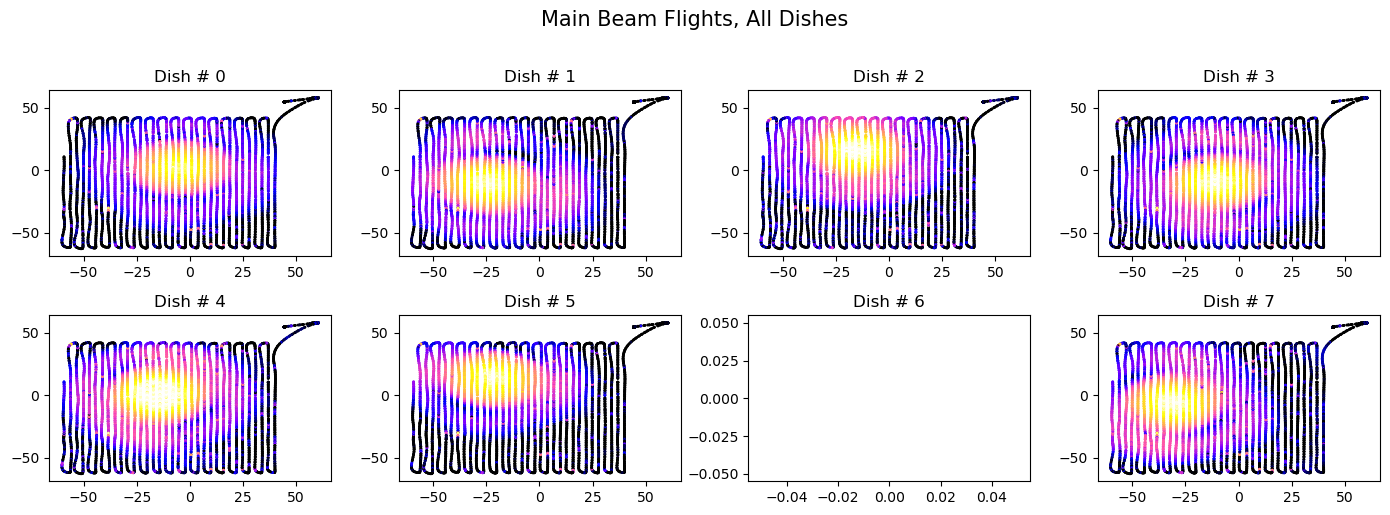

In [7]:
fig=figure(figsize=(14,5))
counter = 1
vmin_ = -105

i = '20210826T195014Z'
for k in range(8):
    dotsize=1
    freq = 900
    inds_on_cut=np.intersect1d(np.arange(len(dict826[i].t_arr_datetime)),dict826[i].inds_on).tolist()
    indsuse = [j for j in inds_on_cut if str(dict826[i].drone_xyz_LC_interp[j,0]) != 'nan']
    x = dict826[i].drone_xyz_LC_interp[indsuse,0]
    y = dict826[i].drone_xyz_LC_interp[indsuse,1]
    
    ax=fig.add_subplot(2,4,counter)
    z = 10*np.log10(np.abs(np.mean(dict826[i].V_bgsub[indsuse,freq:freq+20,2*k+1], axis = 1)))
    ax.scatter(x,y, s=dotsize, c=z, cmap='gnuplot2', vmin = -100)
    ax.set_title('Dish # '+str(k))
    counter +=1

suptitle('Main Beam Flights, All Dishes', y=1.02, fontsize = 15)
tight_layout()

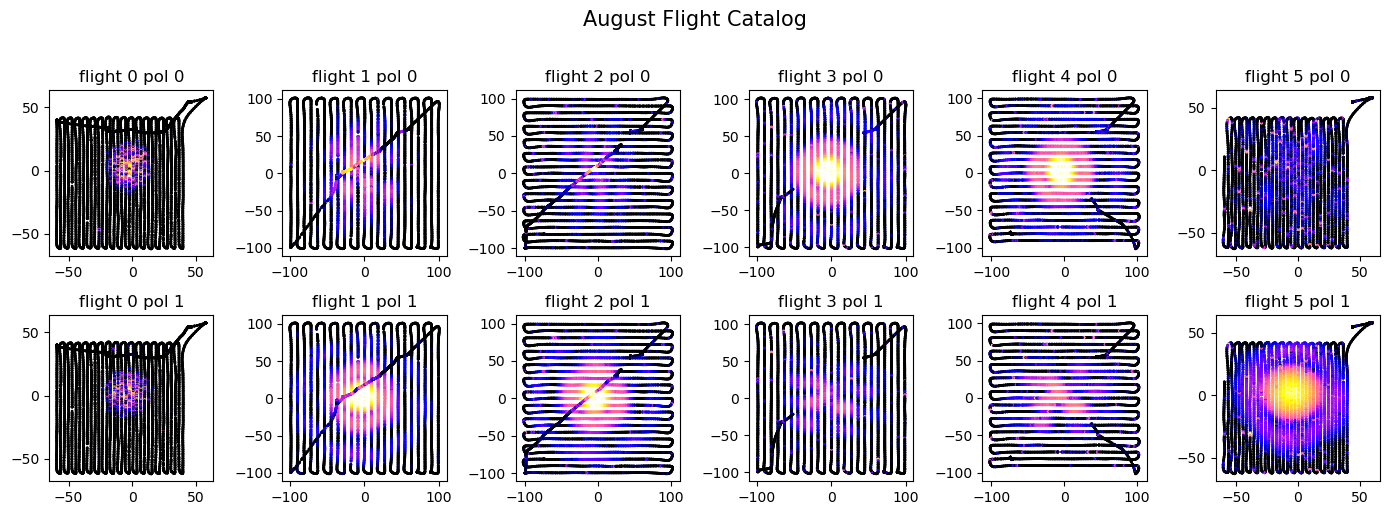

In [8]:
fig=figure(figsize=(14,5))
counter = 1
vmin_ = -105

for k, i in enumerate(keys826):
    dotsize=1
    freq = 900
    inds_on_cut=np.intersect1d(np.arange(len(dict826[i].t_arr_datetime)),dict826[i].inds_on).tolist()
    indsuse = [j for j in inds_on_cut if str(dict826[i].drone_xyz_LC_interp[j,0]) != 'nan']
    x = dict826[i].drone_xyz_LC_interp[indsuse,0]
    y = dict826[i].drone_xyz_LC_interp[indsuse,1]
    
    ax=fig.add_subplot(2,6,counter)
    z = 10*np.log10(np.abs(np.mean(dict826[i].V_bgsub[indsuse,freq:freq+20,0], axis = 1)))
    ax.scatter(x,y, s=dotsize, c=z, cmap='gnuplot2', vmin = -100)
    ax.set_title('flight '+str(k) + ' pol 0')

    ax=fig.add_subplot(2,6,counter+6)
    z = 10*np.log10(np.abs(np.mean(dict826[i].V_bgsub[indsuse,freq:freq+20,1], axis = 1)))
    ax.scatter(x,y, s=dotsize, c=z, cmap='gnuplot2', vmin = -100)
    ax.set_title('flight '+str(k) + ' pol 1')
    counter +=1

suptitle('August Flight Catalog', y=1.02, fontsize = 15)
tight_layout()

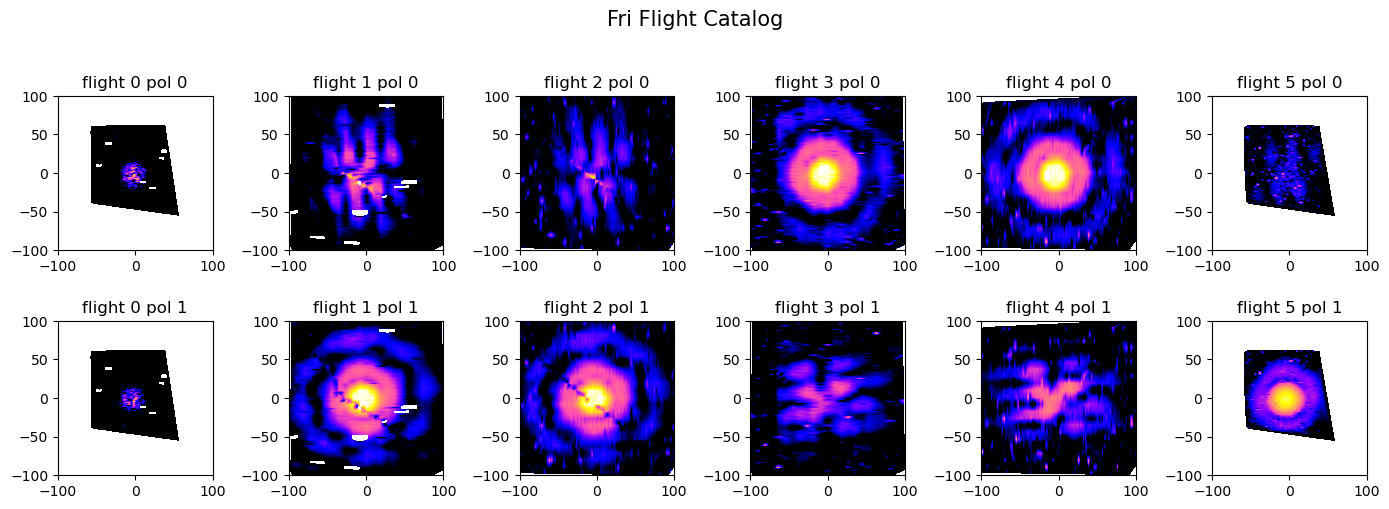

In [9]:
fig=figure(figsize=(14,5))
counter = 1
vmin_ = -105

for k, i in enumerate(keys826):
    dotsize=2
    freq = 900
    inds_on_cut=np.intersect1d(np.arange(len(dict826[i].t_arr_datetime)),dict826[i].inds_on).tolist()
    indsuse = [j for j in inds_on_cut if str(dict826[i].drone_xyz_LC_interp[j,0]) != 'nan']
    x = dict826[i].drone_xyz_LC_interp[indsuse,0]
    y = dict826[i].drone_xyz_LC_interp[indsuse,1]
    X,Y = np.meshgrid(np.linspace(-100,100,2000), np.linspace(-100,100,2000))
    
    ax=fig.add_subplot(2,6,counter)
    z = 10*np.log10(np.abs(np.mean(dict826[i].V_bgsub[indsuse,freq:freq+20,0], axis = 1)))
    Z0 = griddata((x,y), z, (X,Y))
    ax.imshow(Z0, extent=(-100,100,-100,100), cmap='gnuplot2', vmin = -100)
    ax.set_title('flight '+str(k) + ' pol 0')

    ax=fig.add_subplot(2,6,counter+6)
    z = 10*np.log10(np.abs(np.mean(dict826[i].V_bgsub[indsuse,freq:freq+20,1], axis = 1)))
    Z0 = griddata((x,y), z, (X,Y))
    ax.imshow(Z0, extent=(-100,100,-100,100), cmap='gnuplot2', vmin = -100)
    ax.set_title('flight '+str(k) + ' pol 1')
    counter +=1

suptitle('Fri Flight Catalog', y=1.02, fontsize = 15)
tight_layout()

In [10]:
def twoD_Gaussian(v, *params):
    [amplitude, xo, yo, sigma_x, sigma_y, theta, offset] = params
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((v[0]-xo)**2) + 2*b*(v[0]-xo)*(v[1]-yo) 
                            + c*((v[1]-yo)**2)))
    return g.ravel()

In [11]:
num = 5 # looking at flight number 5 from 8/26

freq = 900 #look at frequency index 900

#find indices where source is on
inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist() 

#find indices where there are no nans in position
indsuse = [i for i in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[i,0]) != 'nan']

x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z = (np.abs(np.mean(dict826[keys826[num]].V[indsuse,freq:freq+10,1], axis = 1))) # linear power, units uncalibrated, averaged over 10 frequency bins

#fit 2D gaussian
initial_guess = (1e-5, -5, 2, 7, 7, 0, 1e-7)
popt5, pcov = opt.curve_fit(twoD_Gaussian, (x, y), z, p0=initial_guess)

print('fit params = ', popt5)

fit params =  [ 7.39178786e-08 -4.65567247e+00  2.18151055e+00  9.73743103e+00
  9.00544088e+00  8.38070965e-02  2.76682820e-09]


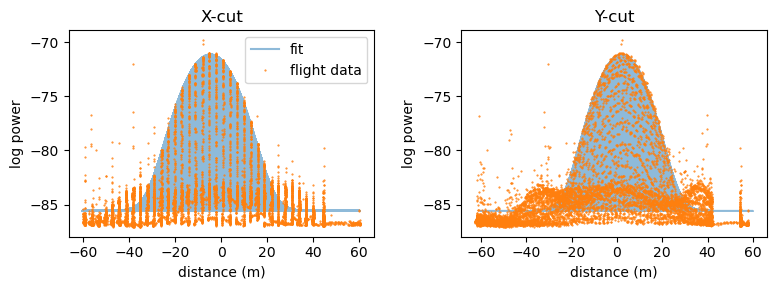

In [12]:
#check fitting by eye

x1 = np.linspace(-60,60,1000)
y1 = np.linspace(-60,60,1000)
X1,Y1 = np.meshgrid(x1,y1)
Z5 = 10*np.log10(twoD_Gaussian((X1,Y1),*popt5))


fig=figure(figsize=(8,3))
ax=fig.add_subplot(121)

ax.plot(X1.ravel(),Z5, alpha = 0.5, label = 'fit')
ax.plot(x,10*np.log10(z),'.', markersize = 1, label = 'flight data')
ax.set_ylabel('log power')
ax.set_xlabel('distance (m)')
ax.set_title('X-cut')
ax.legend()

ax=fig.add_subplot(122)
ax.plot(Y1.ravel(),Z5, alpha = 0.5)
ax.plot(y,10*np.log10(z),'.', markersize = 1)
ax.set_ylabel('log power')
ax.set_xlabel('distance (m)')
ax.set_title('Y-cut')
tight_layout()


fit params =  [ 1.58407605e-07 -2.13490967e+00 -4.78722538e-01  1.25833440e+01
  8.35254308e+00 -5.34581977e-01  2.37757545e-09]


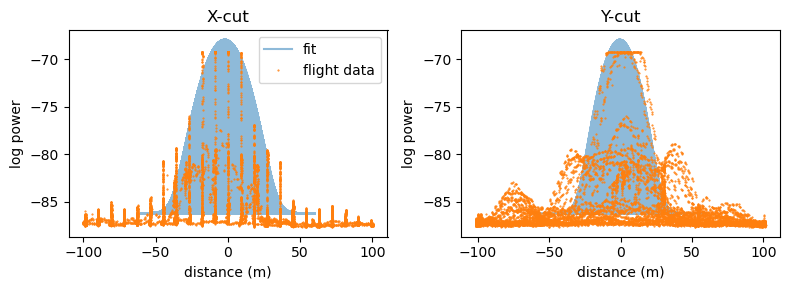

In [13]:
#will be harder to fit for gaussian in high powered flights, note flat tops

#check fitting by eye

num = 1 # looking at flight number 5 from 8/26

freq = 900 #look at frequency index 900
inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist() 
indsuse = [i for i in inds_on_cut if str(dict826[keys826[num]].drone_xyz_LC_interp[i,0]) != 'nan']

x = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,0]
y = dict826[keys826[num]].drone_xyz_LC_interp[indsuse,1]
z = (np.abs(np.mean(dict826[keys826[num]].V[indsuse,freq:freq+10,1], axis = 1))) # linear power, units uncalibrated, averaged over 10 frequency bins
initial_guess = (1e-5, -5, 2, 7, 7, 0, 1e-7)
popt1, pcov = opt.curve_fit(twoD_Gaussian, (x, y), z, p0=initial_guess)
print('fit params = ', popt1)

Z1 = 10*np.log10(twoD_Gaussian((X1,Y1),*popt1))

fig=figure(figsize=(8,3))
ax=fig.add_subplot(121)

ax.plot(X1.ravel(),Z1, alpha = 0.5, label = 'fit')
ax.plot(x,10*np.log10(z),'.', markersize = 1, label = 'flight data')
ax.set_ylabel('log power')
ax.set_xlabel('distance (m)')
ax.set_title('X-cut')
ax.legend()

ax=fig.add_subplot(122)
ax.plot(Y1.ravel(),Z1, alpha = 0.5)
ax.plot(y,10*np.log10(z),'.', markersize = 1)
ax.set_ylabel('log power')
ax.set_xlabel('distance (m)')
ax.set_title('Y-cut')
tight_layout()

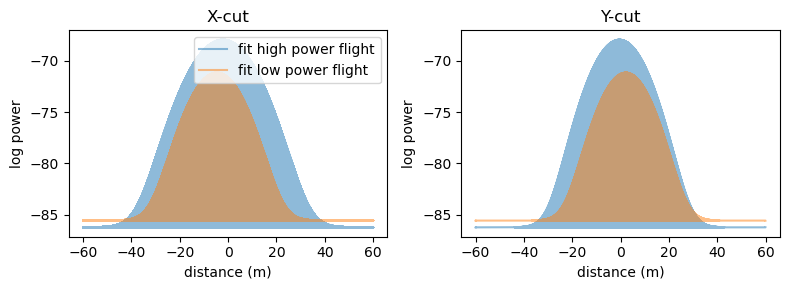

In [14]:


fig=figure(figsize=(8,3))
ax=fig.add_subplot(121)

ax.plot(X1.ravel(),Z1, alpha = 0.5, label = 'fit high power flight')
ax.plot(X1.ravel(),Z5, alpha = 0.5, label = 'fit low power flight')
ax.set_ylabel('log power')
ax.set_xlabel('distance (m)')
ax.set_title('X-cut')
ax.legend()

ax=fig.add_subplot(122)
ax.plot(Y1.ravel(),Z1, alpha = 0.5)
ax.plot(Y1.ravel(),Z5, alpha = 0.5)
ax.set_ylabel('log power')
ax.set_xlabel('distance (m)')
ax.set_title('Y-cut')
tight_layout()

In [16]:
j = 1
find = 900
tempconcat=dict826[keys826[5]]

tacut=tempconcat.t_index[tempconcat.V[:,find,j]<0.999*(np.nanmax(tempconcat.V[:,find,j]))]
txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
## data points for fit:
mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
mbV=tempconcat.V[ttcut,find,j]
mb_input_data=np.array([mbx,mby,mbV])
## shared params:
amp0=np.nanmax(mbV)
bg0=np.nanmin(mbV)
x00=tempconcat.dish_coords[int(j/2),0]
y00=tempconcat.dish_coords[int(j/2),1]
## airy params:
rad0=25.0
## 2dgauss params:
xsig0=6.0
ysig0=6.0
theta0=0.0
pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
Gpopt5=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x


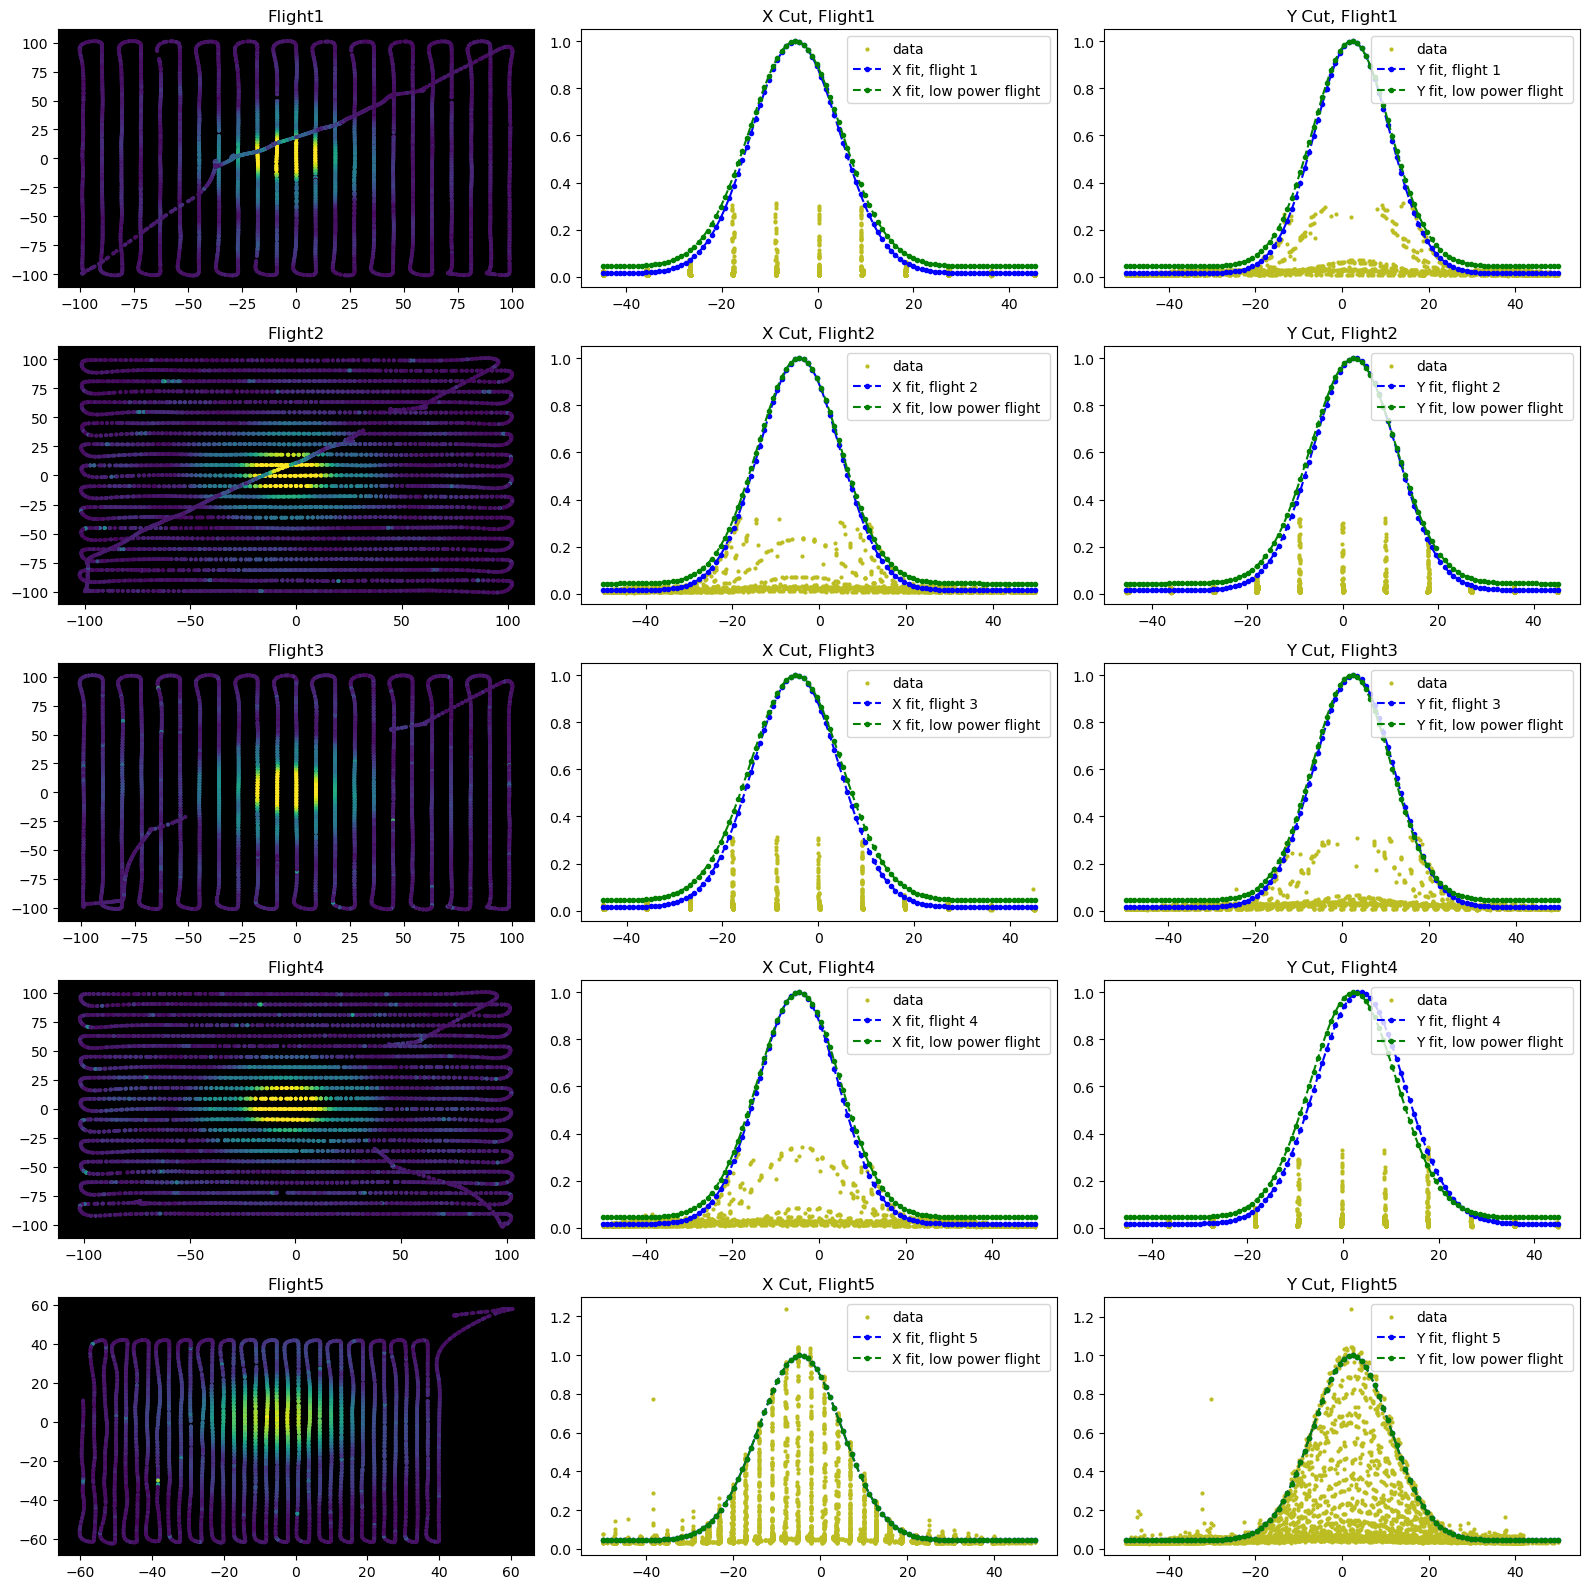

In [17]:

fig=figure(figsize=(16,16))

find = 900

for num in range(1,6):
    if num in [1,2,5]: j = 1
    else: j = 0
    tempconcat=dict826[keys826[num]]

    tacut=tempconcat.t_index[tempconcat.V[:,find,j]<0.999*(np.nanmax(tempconcat.V[:,find,j]))]
    txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
    tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
    tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
    ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
    inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
    ## data points for fit:
    mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
    mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
    mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
    mbV=tempconcat.V[ttcut,find,j]
    mb_input_data=np.array([mbx,mby,mbV])
    ## shared params:
    amp0=np.nanmax(mbV)
    bg0=np.nanmin(mbV)
    x00=tempconcat.dish_coords[int(j/2),0]
    y00=tempconcat.dish_coords[int(j/2),1]
    ## airy params:
    rad0=25.0
    ## 2dgauss params:
    xsig0=6.0
    ysig0=6.0
    theta0=0.0
    pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
    Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
    
    ax=fig.add_subplot(5,3,3*(num-1)+1)
    ax.set_title('Flight' + str(num))
    ax.set_facecolor('k')
    ax.scatter(tempconcat.drone_xyz_LC_interp[inds_on_cut,0],tempconcat.drone_xyz_LC_interp[inds_on_cut,1],\
               c=tempconcat.V[inds_on_cut,find,j], norm=LogNorm(), s = 3)

    
    ax=fig.add_subplot(5,3,3*(num-1)+2)

    ## PLOT 1
#     ax=ax1
    ax.set_title('X Cut, Flight' + str(num)) 
    zplot = Gauss_2d_LC_func_gen(Gpopt,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt[3]*np.ones(100))
    ax.scatter(mbx,mbV/zplot.max(),c='C8',norm=LogNorm(), s = 4, label = 'data')
    ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'b.--',label='X fit, flight ' +str(num))
    zplot = Gauss_2d_LC_func_gen(Gpopt5,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt5[3]*np.ones(100))
    ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'g.--',label='X fit, low power flight ')
    ax.semilogy
    ax.legend(loc = 'upper right')
    
    ax=fig.add_subplot(5,3,3*(num-1)+3)

    ## PLOT 2
#     ax=ax2
    ax.set_title('Y Cut, Flight' + str(num))
    zplot = Gauss_2d_LC_func_gen(Gpopt,Gpopt[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
    ax.scatter(mby,mbV/zplot.max(), c = 'C8',norm=LogNorm(), s = 4, label = 'data')
    ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'b.--',label='Y fit, flight ' +str(num))
    zplot = Gauss_2d_LC_func_gen(Gpopt5,Gpopt5[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
    ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'g.--',label='Y fit, low power flight ')
    ax.semilogy
    ax.legend(loc = 'upper right')

tight_layout()




/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


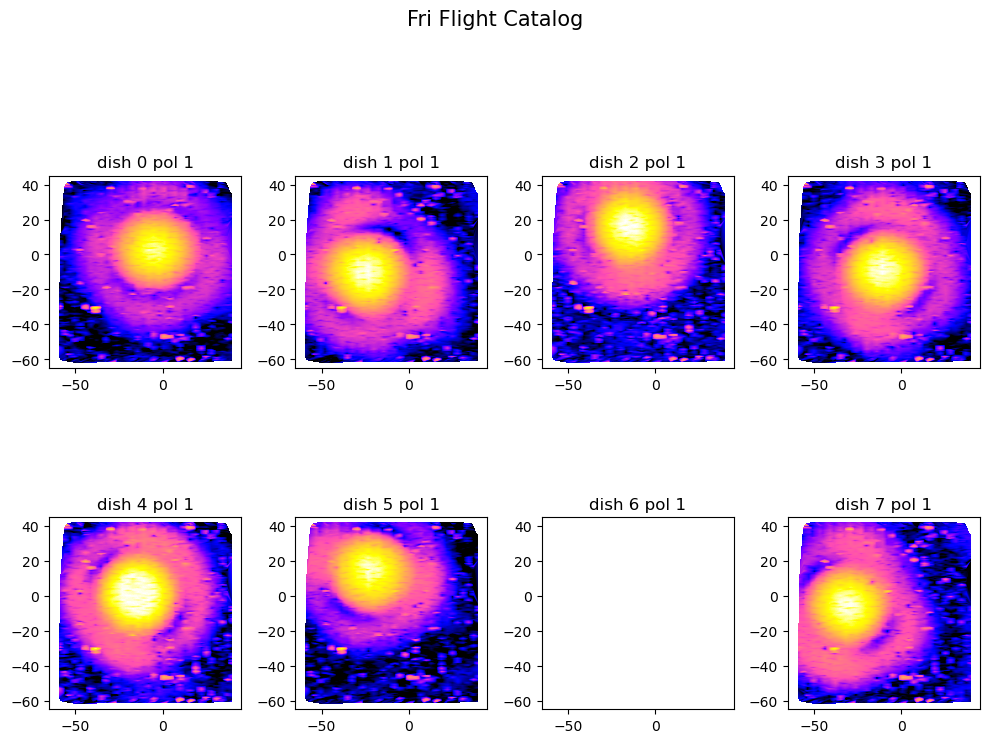

In [18]:
fig=figure(figsize=(10,8))
vmin_ = -105

i = keys826[5]
dotsize=2
freq = 900
inds_on_cut=np.intersect1d(np.arange(len(dict826[i].t_arr_datetime)),dict826[i].inds_on).tolist()
x = dict826[i].drone_xyz_LC_interp[inds_on_cut,0]
y = dict826[i].drone_xyz_LC_interp[inds_on_cut,1]
indsuse = np.where((x>-60)&(x<40))[0]
x = x[indsuse]
y = y[indsuse]
X,Y = np.meshgrid(np.linspace(-65,45,1000), np.linspace(45,-65,1000))
for k in range(8):
    ax=fig.add_subplot(2,4,k+1)
    z = np.abs(np.mean(dict826[i].V_bgsub[np.array(inds_on_cut)[indsuse],freq:freq+10,2*k+1], axis = 1))
    Z0 = griddata((x,y),z, (X,Y))
    ax.imshow(10*np.log10(Z0), extent=(-65,45,-65,45), cmap='gnuplot2', vmin = -105)
    ax.set_title('dish '+str(k) + ' pol 1')

suptitle('Fri Flight Catalog', y=1.02, fontsize = 15)
tight_layout()

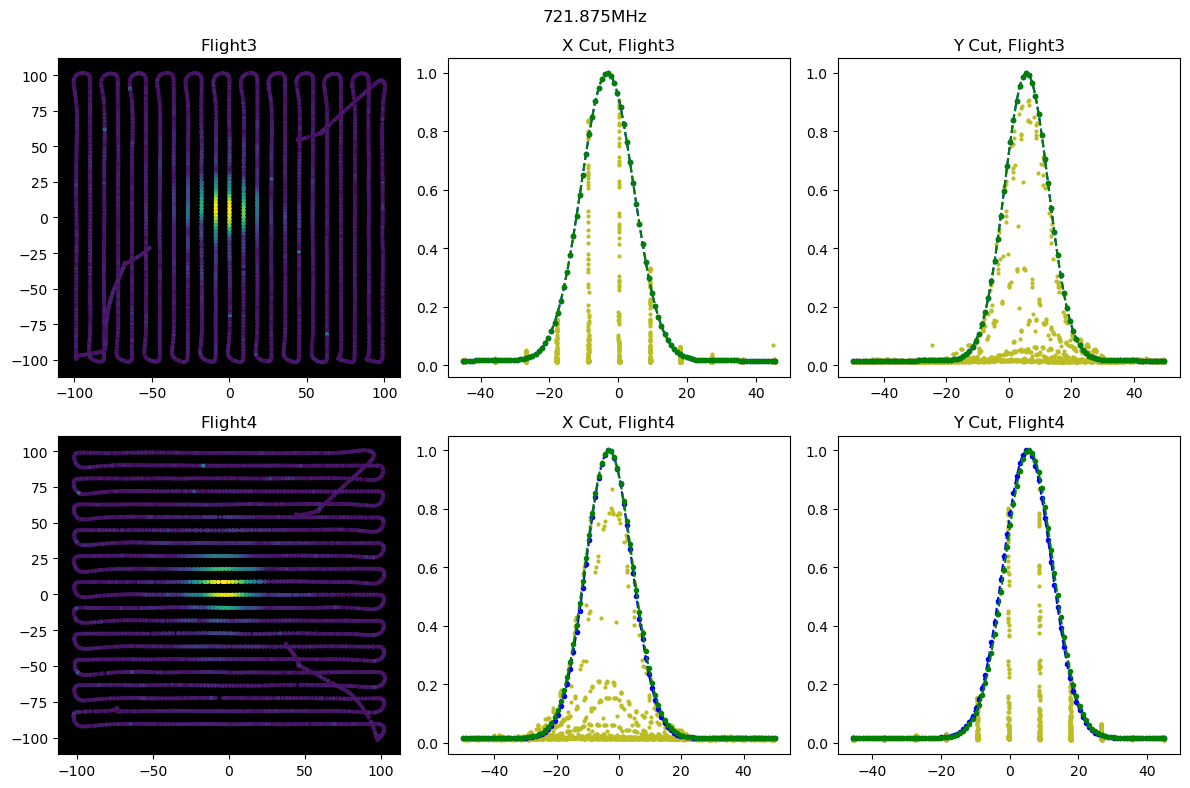

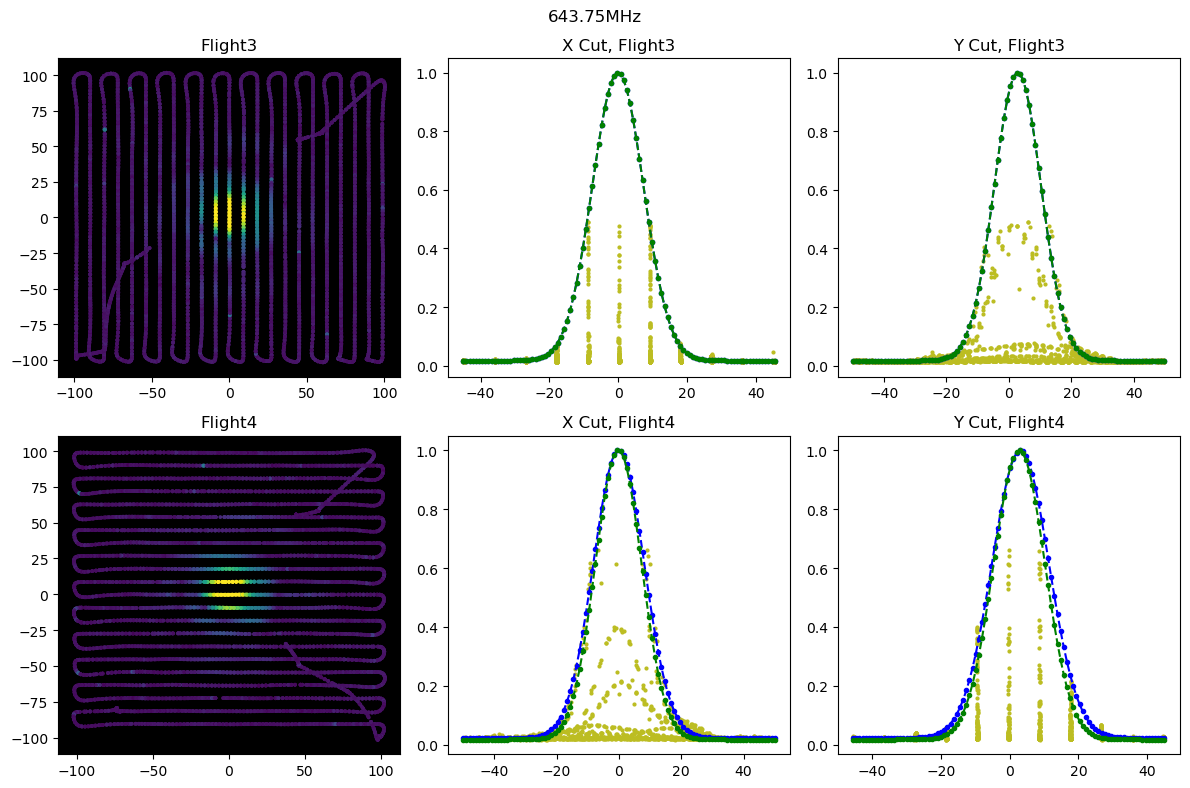

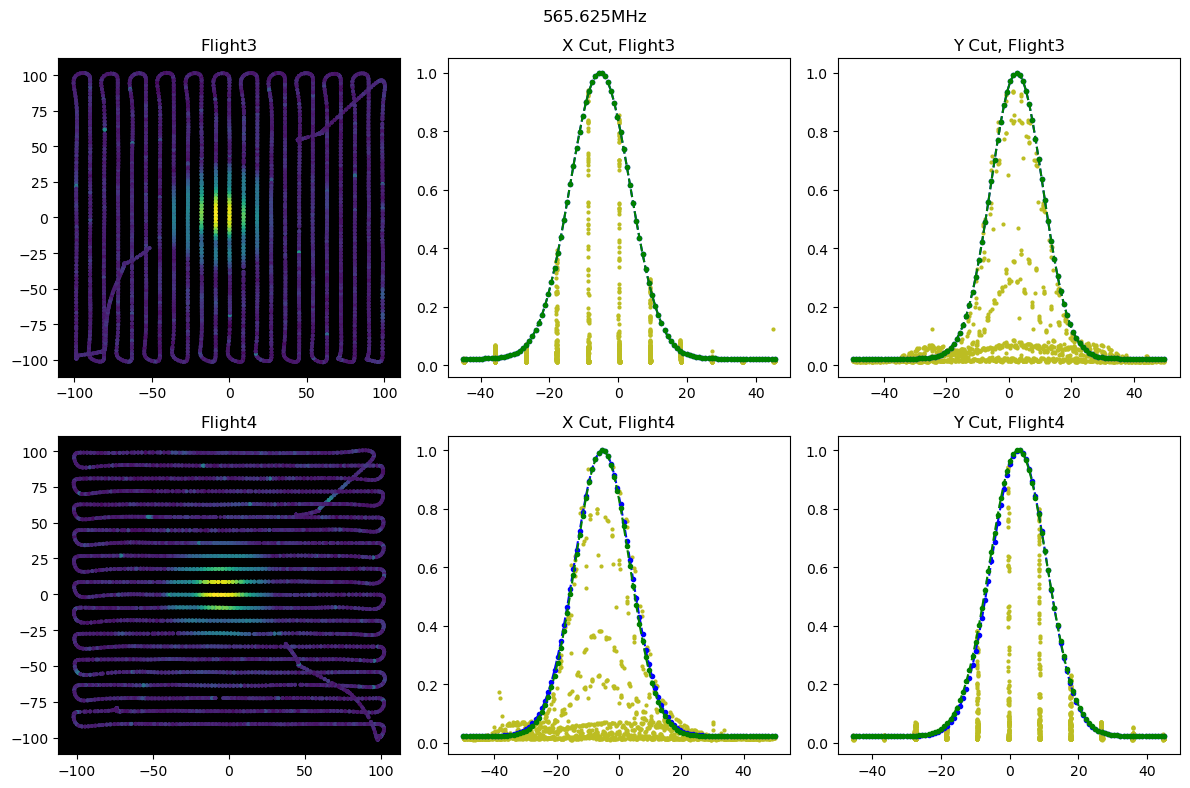

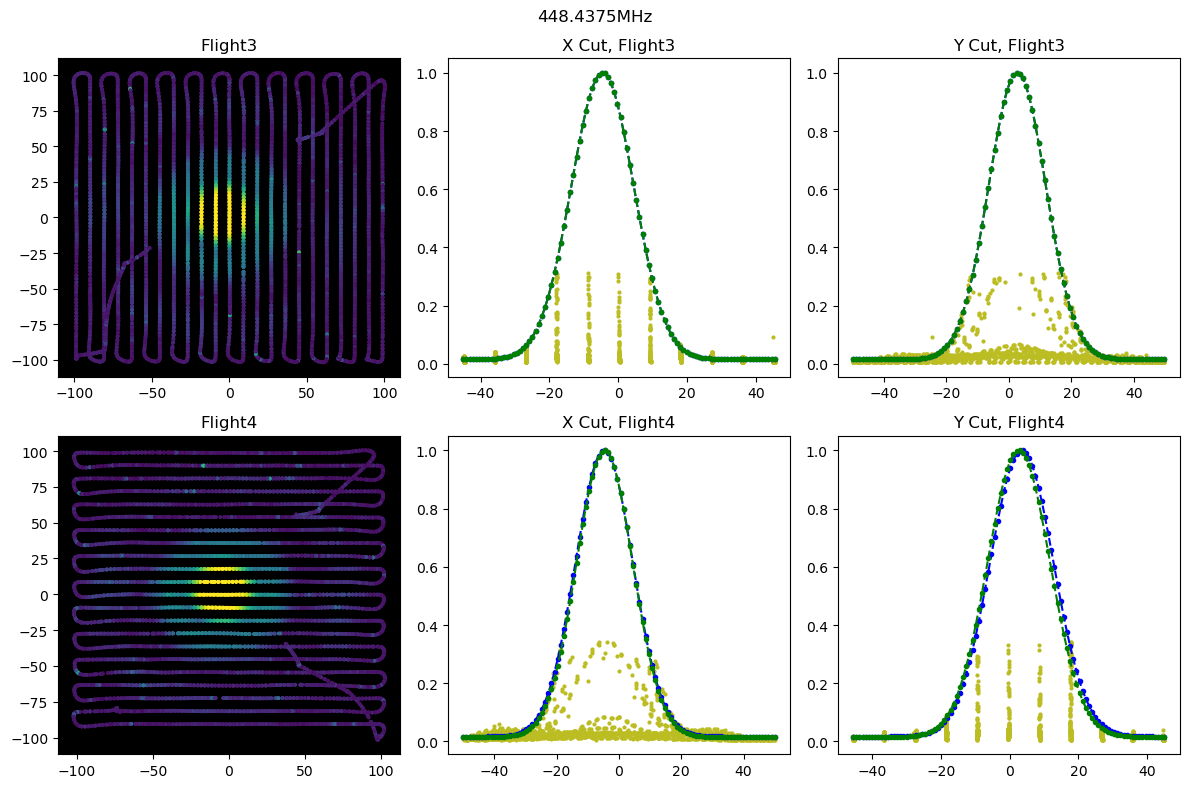

In [41]:
for find in [200, 400, 600, 900]:
    fig=figure(figsize=(12,8))
    for counter, num in enumerate([3,4]):
        if num in [3,4]: j = 0
        else: j = 0
        tempconcat=dict826[keys826[num]]

        tacut=tempconcat.t_index[tempconcat.V[:,find,j]<0.999*(np.nanmax(tempconcat.V[:,find,j]))]
        txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
        tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
        tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
        ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
        inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
        ## data points for fit:
        mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
        mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
        mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
        mbV=tempconcat.V[ttcut,find,j]
        mb_input_data=np.array([mbx,mby,mbV])
        ## shared params:
        amp0=np.nanmax(mbV)
        bg0=np.nanmin(mbV)
        x00=tempconcat.dish_coords[int(j/2),0]
        y00=tempconcat.dish_coords[int(j/2),1]
        ## airy params:
        rad0=25.0
        ## 2dgauss params:
        xsig0=6.0
        ysig0=6.0
        theta0=0.0
        pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
        Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
        if num == 3:
            Gpopt5=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x


        ax=fig.add_subplot(2,3,3*(counter)+1)
        ax.set_title('Flight' + str(num))
        ax.set_facecolor('k')
        ax.scatter(tempconcat.drone_xyz_LC_interp[inds_on_cut,0],tempconcat.drone_xyz_LC_interp[inds_on_cut,1],\
                   c=tempconcat.V[inds_on_cut,find,j], norm=LogNorm(), s = 3)


        ax=fig.add_subplot(2,3,3*(counter)+2)

        ## PLOT 1
    #     ax=ax1
        ax.set_title('X Cut, Flight' + str(num)) 
        zplot = Gauss_2d_LC_func_gen(Gpopt,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt[3]*np.ones(100))
        ax.scatter(mbx,mbV/zplot.max(),c='C8',norm=LogNorm(), s = 4, label = 'data')
        ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'b.--',label='X fit, flight ' +str(num))
        zplot = Gauss_2d_LC_func_gen(Gpopt5,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt5[3]*np.ones(100))
        ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'g.--',label='X fit, low power flight ')
        ax.semilogy
    #     ax.legend(loc = 'upper right')


        ax=fig.add_subplot(2,3,3*(counter)+3)

        ## PLOT 2
    #     ax=ax2
        ax.set_title('Y Cut, Flight' + str(num))
        zplot = Gauss_2d_LC_func_gen(Gpopt,Gpopt[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
        ax.scatter(mby,mbV/zplot.max(), c = 'C8',norm=LogNorm(), s = 4, label = 'data')
        ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'b.--',label='Y fit, flight ' +str(num))
        zplot = Gauss_2d_LC_func_gen(Gpopt5,Gpopt5[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
        ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'g.--',label='Y fit, low power flight ')
        ax.semilogy
        
    #     ax.legend(loc = 'upper right')
    suptitle(str(tempconcat.freq[find])+'MHz', fontsize = 12)
    tight_layout()
    show()



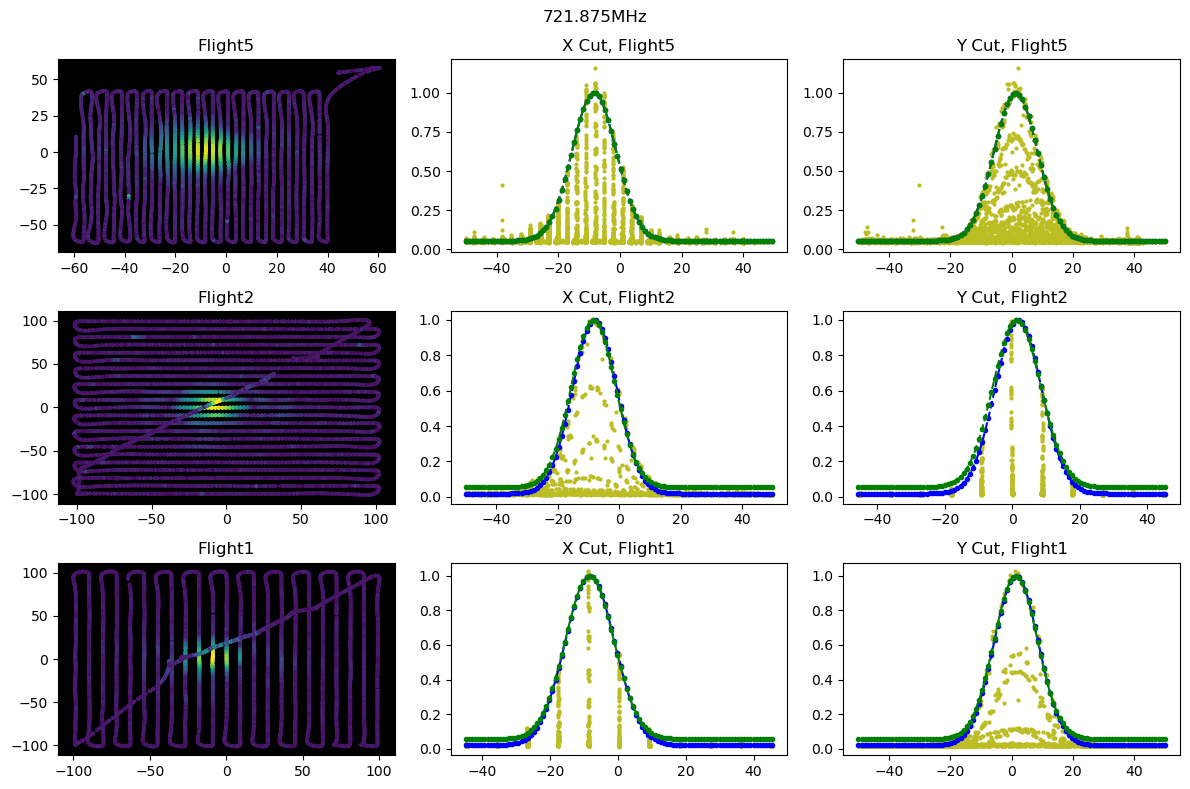

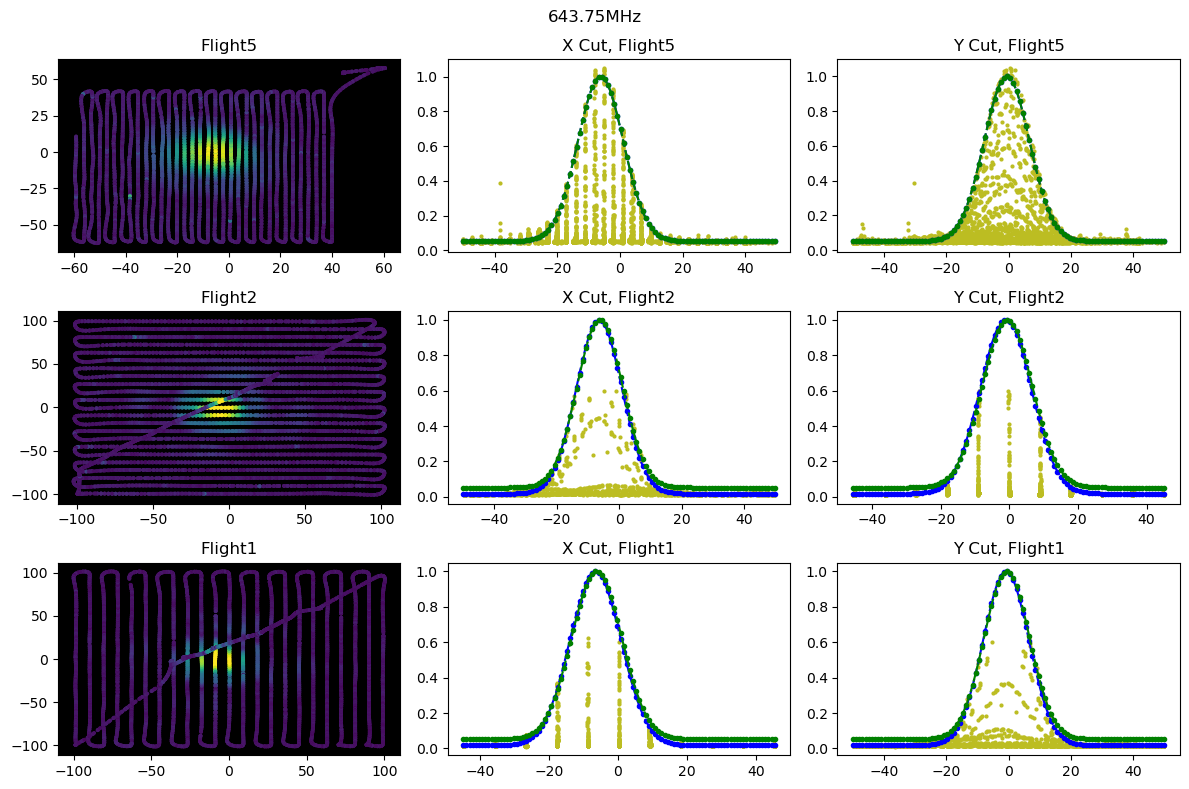

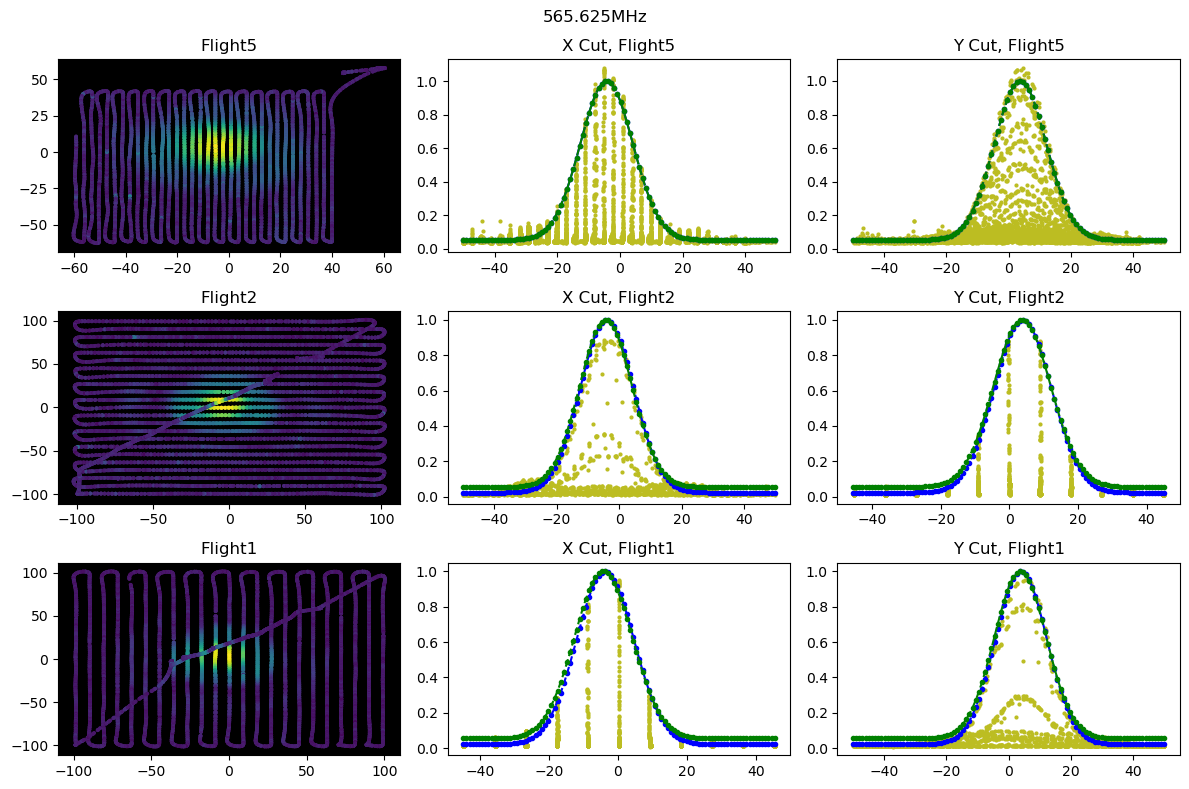

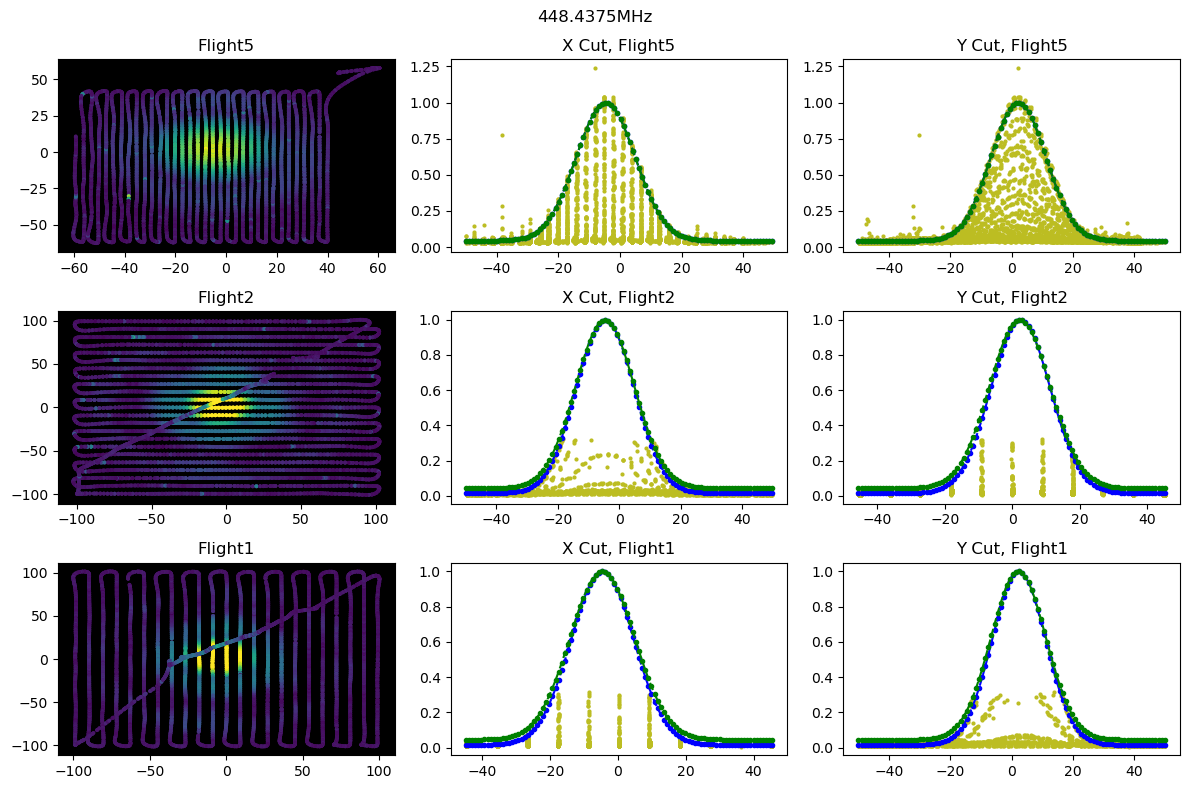

In [22]:
for find in [200, 400, 600, 900]:
    fig=figure(figsize=(12,8))
    for counter, num in enumerate([5,2,1]):
        if num in [1,2,5]: j = 1
        else: j = 0
        tempconcat=dict826[keys826[num]]

        tacut=tempconcat.t_index[tempconcat.V[:,find,j]<0.999*(np.nanmax(tempconcat.V[:,find,j]))]
        txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
        tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
        tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
        ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
        inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
        ## data points for fit:
        mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
        mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
        mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
        mbV=tempconcat.V[ttcut,find,j]
        mb_input_data=np.array([mbx,mby,mbV])
        ## shared params:
        amp0=np.nanmax(mbV)
        bg0=np.nanmin(mbV)
        x00=tempconcat.dish_coords[int(j/2),0]
        y00=tempconcat.dish_coords[int(j/2),1]
        ## airy params:
        rad0=25.0
        ## 2dgauss params:
        xsig0=6.0
        ysig0=6.0
        theta0=0.0
        pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
        Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
        if num == 5:
            Gpopt5=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x


        ax=fig.add_subplot(3,3,3*(counter)+1)
        ax.set_title('Flight' + str(num))
        ax.set_facecolor('k')
        ax.scatter(tempconcat.drone_xyz_LC_interp[inds_on_cut,0],tempconcat.drone_xyz_LC_interp[inds_on_cut,1],\
                   c=tempconcat.V[inds_on_cut,find,j], norm=LogNorm(), s = 3)


        ax=fig.add_subplot(3,3,3*(counter)+2)

        ## PLOT 1
    #     ax=ax1
        ax.set_title('X Cut, Flight' + str(num)) 
        zplot = Gauss_2d_LC_func_gen(Gpopt,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt[3]*np.ones(100))
        ax.scatter(mbx,mbV/zplot.max(),c='C8',norm=LogNorm(), s = 4, label = 'data')
        ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'b.--',label='X fit, flight ' +str(num))
        zplot = Gauss_2d_LC_func_gen(Gpopt5,np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),Gpopt5[3]*np.ones(100))
        ax.plot(np.linspace(np.nanmin(mbx),np.nanmax(mbx),100),zplot/zplot.max(),'g.--',label='X fit, low power flight ')
        ax.semilogy
    #     ax.legend(loc = 'upper right')

        ax=fig.add_subplot(3,3,3*(counter)+3)

        ## PLOT 2
    #     ax=ax2
        ax.set_title('Y Cut, Flight' + str(num))
        zplot = Gauss_2d_LC_func_gen(Gpopt,Gpopt[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
        ax.scatter(mby,mbV/zplot.max(), c = 'C8',norm=LogNorm(), s = 4, label = 'data')
        ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'b.--',label='Y fit, flight ' +str(num))
        zplot = Gauss_2d_LC_func_gen(Gpopt5,Gpopt5[1]*np.ones(100),np.linspace(np.nanmin(mby),np.nanmax(mby),100))
        ax.plot(np.linspace(np.nanmin(mby),np.nanmax(mby),100),zplot/zplot.max(),'g.--',label='Y fit, low power flight ')
        ax.semilogy
    #     ax.legend(loc = 'upper right')
    suptitle(str(tempconcat.freq[find])+'MHz', fontsize = 12)
    tight_layout()
    show()



In [23]:
fitparams = {}
for find in np.arange(100,1000,10):
    fitparams[find] = {}
    for num in [1,2,5][::-1]:
        if num in [1,2,5]: j = 1
        else: j = 0
        tempconcat=dict826[keys826[num]]

        tacut=tempconcat.t_index[tempconcat.V[:,find,j]<0.999*(np.nanmax(tempconcat.V[:,find,j]))]
        txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
        tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
        tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
        ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
        inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
        ## data points for fit:
        mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
        mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
        mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
        mbV=tempconcat.V[ttcut,find,j]
        mb_input_data=np.array([mbx,mby,mbV])
        ## shared params:
        amp0=np.nanmax(mbV)
        bg0=np.nanmin(mbV)
        x00=tempconcat.dish_coords[int(j/2),0]
        y00=tempconcat.dish_coords[int(j/2),1]
        ## airy params:
        rad0=25.0
        ## 2dgauss params:
        xsig0=6.0
        ysig0=6.0
        theta0=0.0
        pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
        Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
        fitparams[find][num] = Gpopt

In [27]:
dict826[list(dict826.keys())[5]].n_dishes
x,y = np.meshgrid(np.linspace(-100,100,100), np.linspace(-100,100,100))

num = 5 
fits_all_norm = {}
for num in np.arange(0,6,1):
    fits = np.zeros((90, dict826[list(dict826.keys())[num]].n_dishes, 7))
    for i, find in enumerate(np.arange(100,1000,10)):
        for j, pol in enumerate(np.arange(1,16,2)):
            try:
                tempconcat=dict826[keys826[num]]
                tacut=tempconcat.t_index[tempconcat.V[:,find,pol]<0.999*(np.nanmax(tempconcat.V[:,find,pol]))]
                txcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,0])<50.0]
                tycut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,1])<50.0]
                tzcut=tempconcat.t_index[np.abs(tempconcat.drone_xyz_LC_interp[:,2])>150.0]
                ttcut=np.intersect1d(np.intersect1d(np.intersect1d(np.intersect1d(txcut,tycut),tzcut),tacut),tempconcat.inds_on)
                inds_on_cut=np.intersect1d(np.arange(len(dict826[keys826[num]].t_arr_datetime)),dict826[keys826[num]].inds_on).tolist()
                ## data points for fit:
                mbx=tempconcat.drone_xyz_LC_interp[ttcut,0]
                mby=tempconcat.drone_xyz_LC_interp[ttcut,1]
                mbz=tempconcat.drone_xyz_LC_interp[ttcut,2]
                mbV=tempconcat.V[ttcut,find,pol]
                mbV=np.mean(np.abs(tempconcat.V_bgsub[ttcut,find:find+10,pol]), axis = 1)                
                mb_input_data=np.array([mbx,mby,mbV])
                ## shared params:
                amp0=np.nanmax(mbV)
                bg0=np.nanmin(mbV)
                x00=tempconcat.dish_coords[int(pol/2),0]
                y00=tempconcat.dish_coords[int(pol/2),1]
                ## airy params:
                rad0=25.0
                ## 2dgauss params:
                xsig0=6.0
                ysig0=6.0
                theta0=0.0
                pG=np.array([amp0,x00,xsig0,y00,ysig0,theta0,bg0])
                Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=pG,args=mb_input_data).x
                z = Gauss_2d_LC_func_gen(Gpopt,x,y)
                z = z/z.max()
                Gpopt=least_squares(Gauss_2d_LC_opt_gen,x0=Gpopt,args=[x.ravel(),y.ravel(),z.ravel()]).x            
                for k, param in enumerate(Gpopt):
                    fits[i,j,k] = param
            except: pass
    fits_all_norm[num] = fits

/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


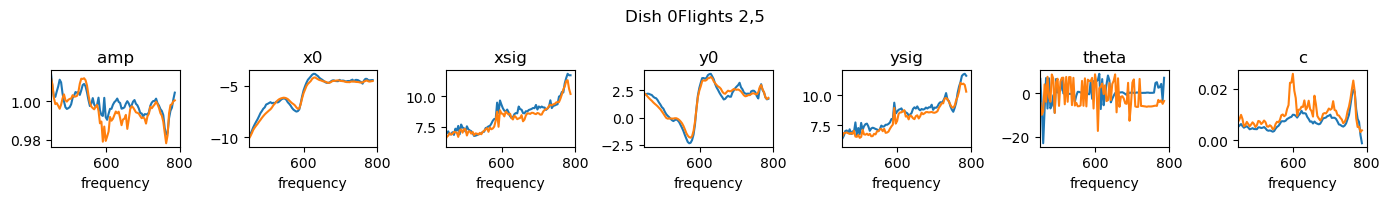

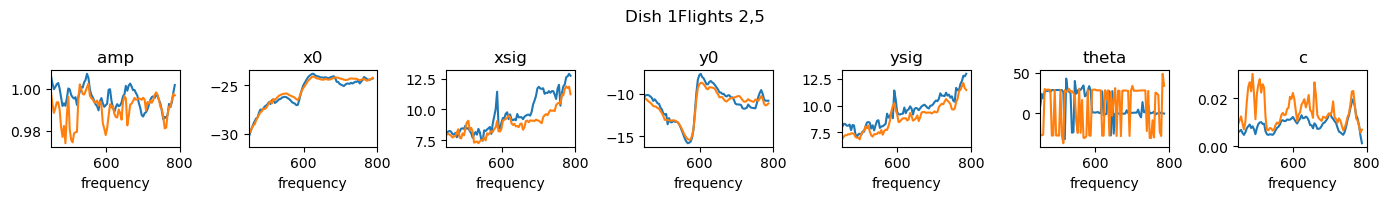

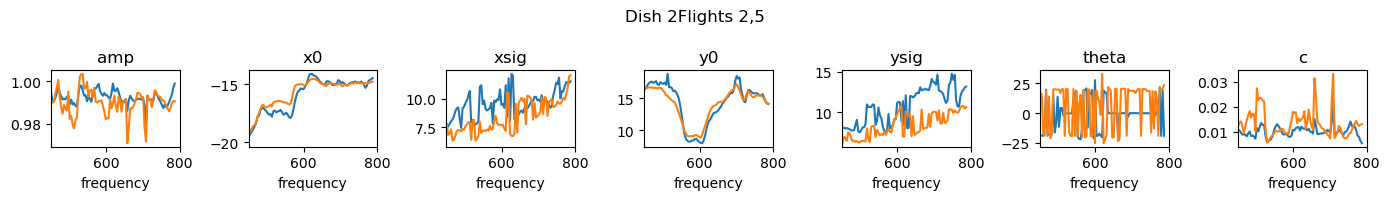

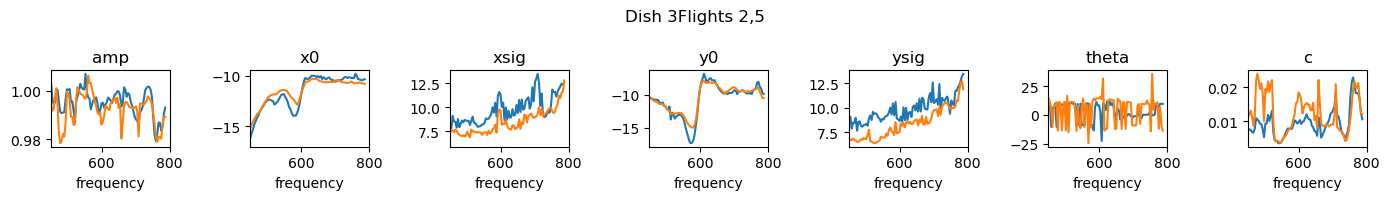

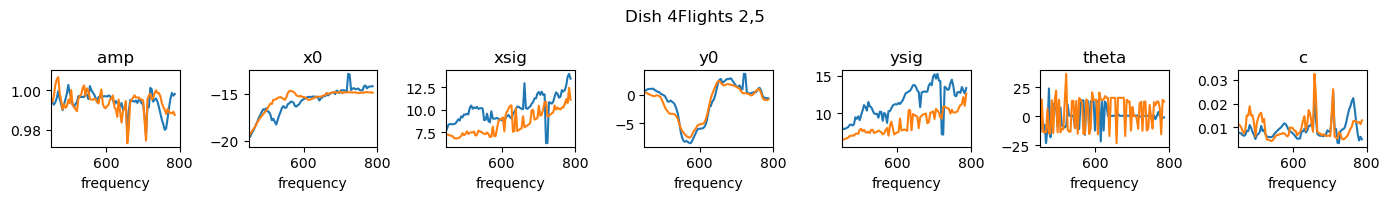

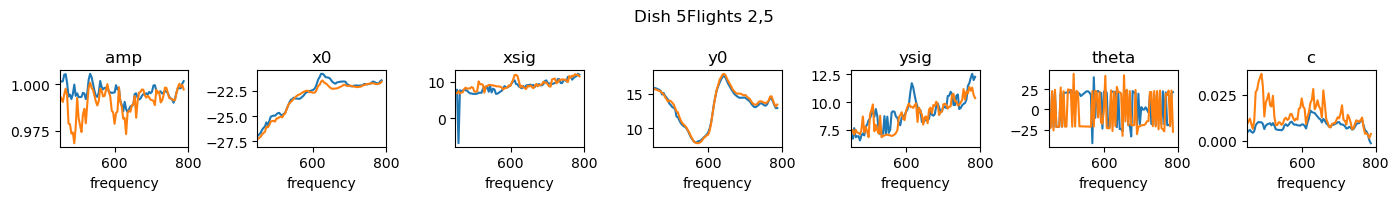

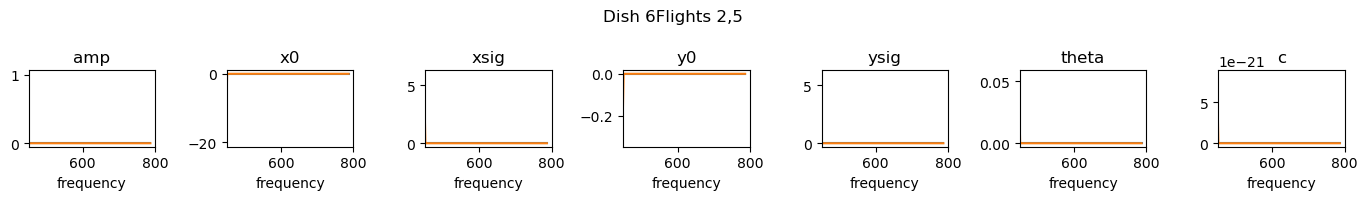

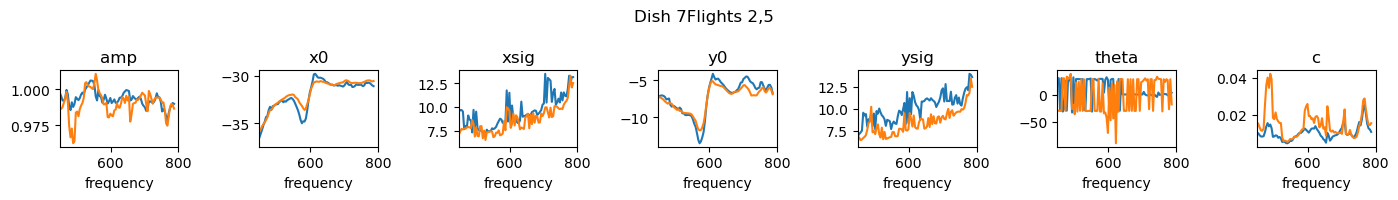

In [29]:
param_labels = ['amp','x0','xsig','y0','ysig','theta','c']

for dishnum in range(8):
    fig=figure(figsize=(14,2))
    for k in range(len(fits_all_norm[num][0,0,:])):
        ax=fig.add_subplot(1,7,k+1)
        for num in [2,5]:
            try:
                ax.plot(np.linspace(400,800,1024)[list(fitparams.keys())], fits_all_norm[num][:,dishnum,k], label = i)
            except: pass
        # ylim(0.75,1)
        ax.set_title(param_labels[k])
        ax.set_xlabel('frequency')
        ax.set_xlim(450,800)
#         med = fits_all_norm[num][:,i,k][80]
    #     ax.set_ylim(med-med/2, med+med/2)
    suptitle('Dish '+str(dishnum)+'Flights 2,5')
    tight_layout()
    show()


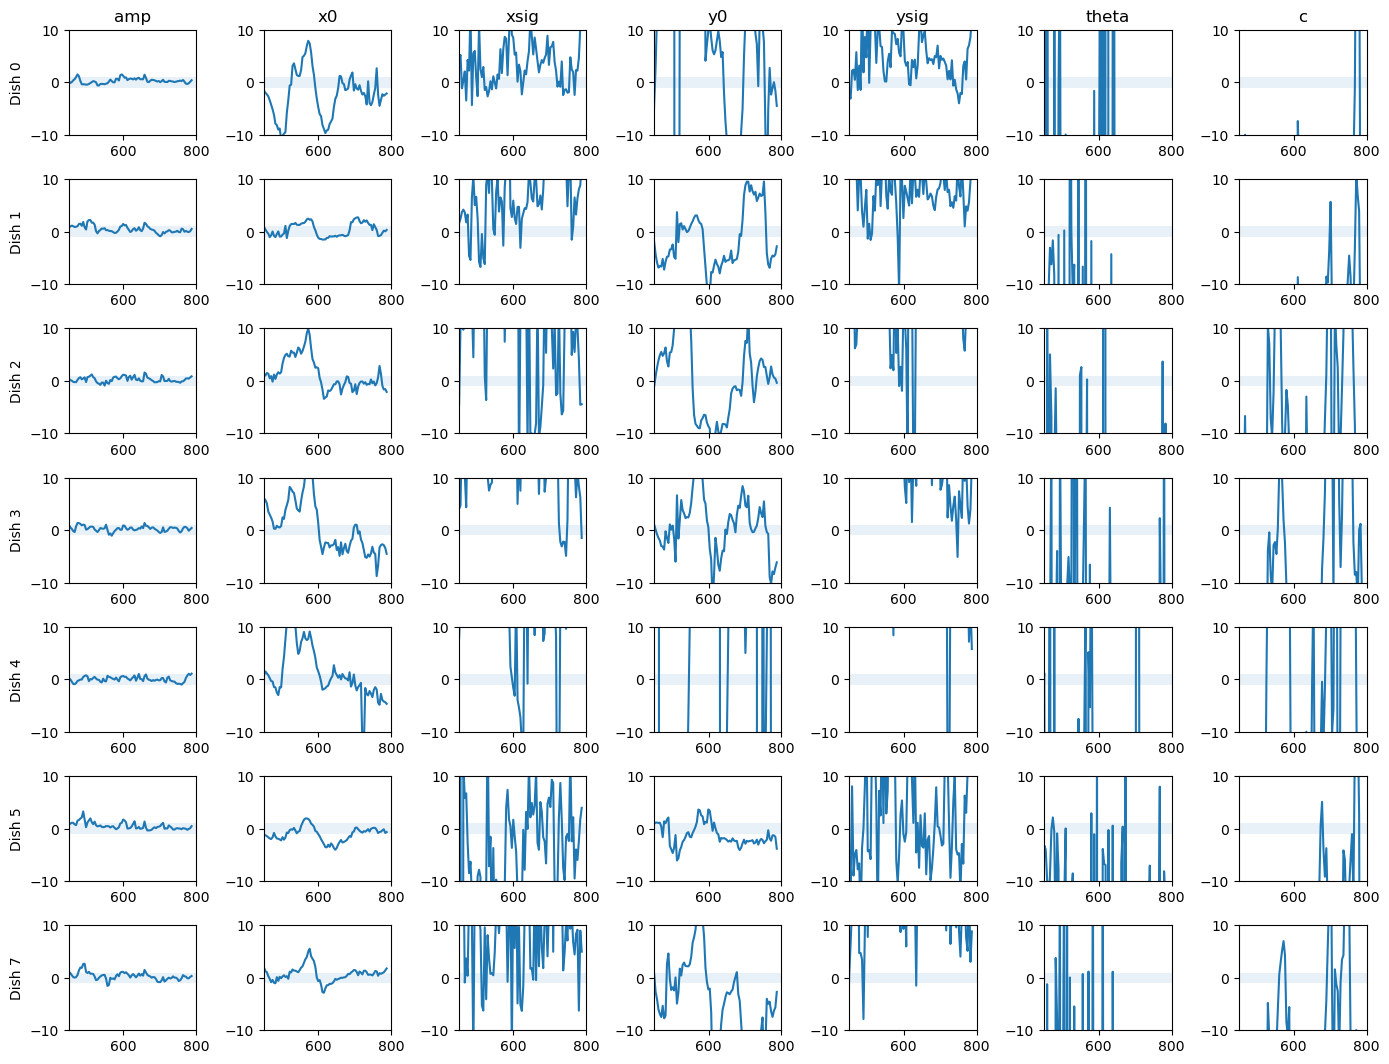

In [31]:
param_labels = ['amp','x0','xsig','y0','ysig','theta','c']

fig=figure(figsize=(14,12))

for j, dishnum in enumerate([0,1,2,3,4,5,7]):
    for k in range(len(fits_all_norm[num][0,0,:])):
        ax=fig.add_subplot(8,7,j*7+k+1)
        try:
            ax.plot(np.linspace(400,800,1024)[list(fitparams.keys())], \
                    100*(fits_all_norm[2][:,dishnum,k]-fits_all_norm[5][:,dishnum,k])/fits_all_norm[5][:,dishnum,k], label = i)
        except: pass
        # ylim(0.75,1)
        if dishnum == 0: ax.set_title(param_labels[k])
        if k == 0: ax.set_ylabel('Dish '+str(dishnum))
#         ax.set_xlabel('frequency')
        ax.set_xlim(450,800)
        ax.set_ylim(-10,10)
        ax.axhspan(-1,1,alpha = 0.1)
#         med = fits_all_norm[num][:,i,k][80]
    #     ax.set_ylim(med-med/2, med+med/2)
    tight_layout()


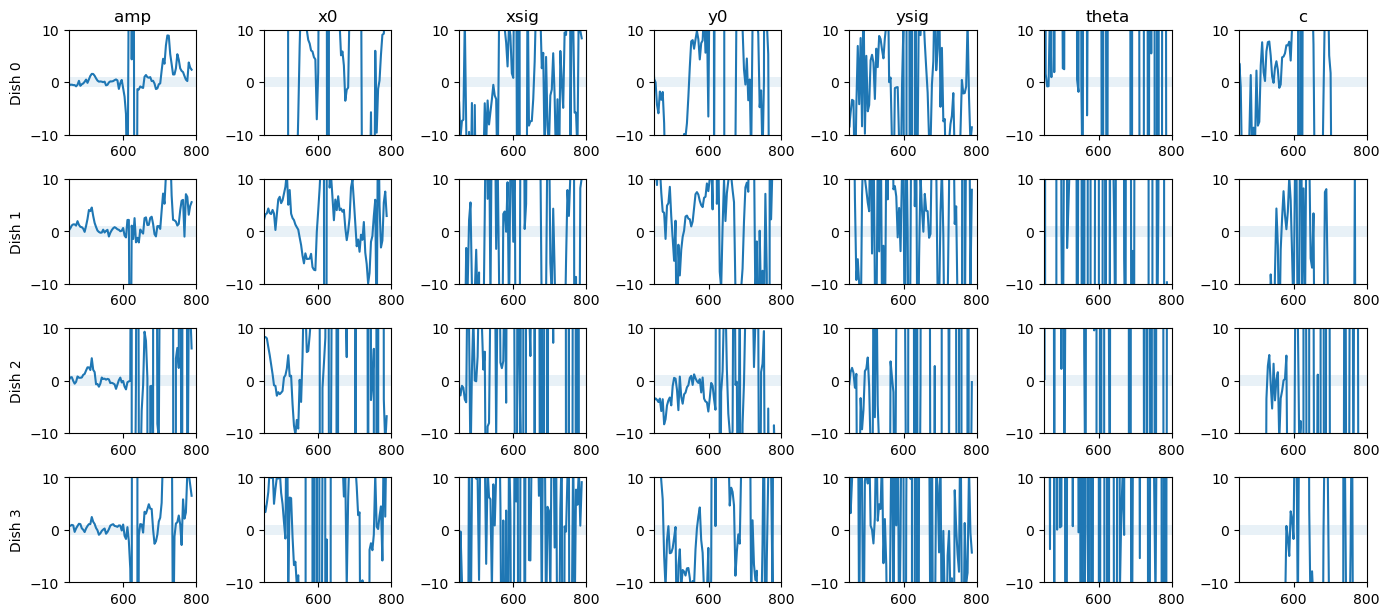

In [46]:
param_labels = ['amp','x0','xsig','y0','ysig','theta','c']

fig=figure(figsize=(14,12))

for j, dishnum in enumerate([0,1,2,3]):
    for k in range(len(fits_all_norm[num][0,0,:])):
        ax=fig.add_subplot(8,7,j*7+k+1)
        try:
            ax.plot(np.linspace(400,800,1024)[list(fitparams.keys())], \
                    100*(fits_all_norm[4][:,dishnum,k]-fits_all_norm[3][:,dishnum,k])/fits_all_norm[4][:,dishnum,k], label = i)
        except: pass
        # ylim(0.75,1)
        if dishnum == 0: ax.set_title(param_labels[k])
        if k == 0: ax.set_ylabel('Dish '+str(dishnum))
#         ax.set_xlabel('frequency')
        ax.set_xlim(450,800)
        ax.set_ylim(-10,10)
        ax.axhspan(-1,1,alpha = 0.1)
#         med = fits_all_norm[num][:,i,k][80]
    #     ax.set_ylim(med-med/2, med+med/2)
    tight_layout()


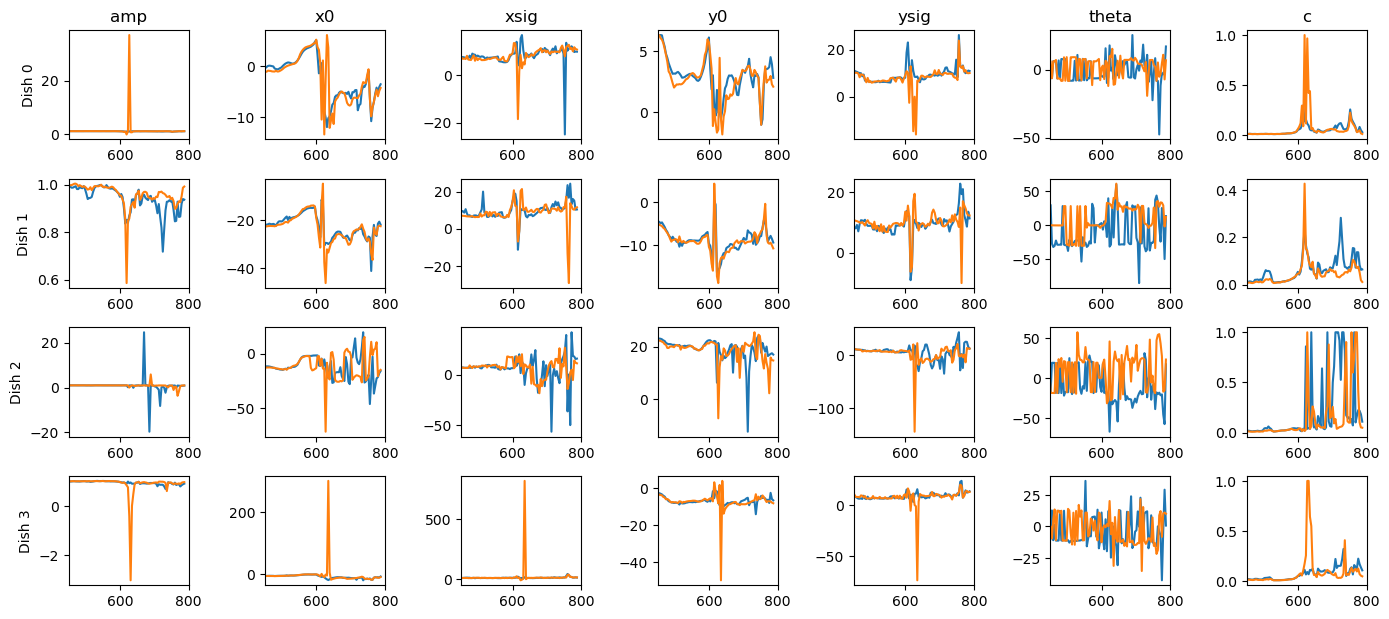

In [48]:
param_labels = ['amp','x0','xsig','y0','ysig','theta','c']

fig=figure(figsize=(14,12))

for j, dishnum in enumerate([0,1,2,3]):
    for k in range(len(fits_all_norm[num][0,0,:])):
        ax=fig.add_subplot(8,7,j*7+k+1)
        for num in [3,4]:
            try:
                ax.plot(np.linspace(400,800,1024)[list(fitparams.keys())], fits_all_norm[num][:,dishnum,k], label = i)
            except: pass
        # ylim(0.75,1)
        if dishnum == 0: ax.set_title(param_labels[k])
        if k == 0: ax.set_ylabel('Dish '+str(dishnum))
#         ax.set_xlabel('frequency')
        ax.set_xlim(450,800)
#         med = fits_all_norm[num][:,i,k][80]
    #     ax.set_ylim(med-med/2, med+med/2)
    tight_layout()
